<a href="https://colab.research.google.com/github/darwtech/dc-nlp/blob/main/dcnlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Desafìo NLP
## DARWIN DANIEL CHAVEZ VEGA

In [1]:


!pip -q install -U pip
!pip -q install scikit-learn pandas numpy matplotlib seaborn imbalanced-learn
!pip -q install transformers datasets accelerate torch --extra-index-url https://download.pytorch.org/whl/cu121 -q

import os, sys, random, math, re, json, time, gc, pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

import torch
import tensorflow as tf

print("Python:", sys.version)
print("Torch:", torch.__version__, "CUDA:", torch.cuda.is_available())
print("TF:", tf.__version__)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 35.8 MB/s eta 0:00:00
Python: 3.12.11 (main, Jun  4 2025, 08:56:18) [GCC 11.4.0]
Torch: 2.8.0+cu126 CUDA: False
TF: 2.19.0


In [12]:

#@title Descarga del repo y localización de splits
import os, glob, pandas as pd

if not os.path.exists("EmoEvent"):
    !git clone -q https://github.com/fmplaza/EmoEvent.git

# Detectar archivos de splits (train/dev/test) en /splits
split_dir = "EmoEvent/splits"
files = glob.glob(os.path.join(split_dir, "**/*.*"), recursive=True)
print("Archivos encontrados:", len(files))
files[:10]


Archivos encontrados: 6


['EmoEvent/splits/en/dev.tsv',
 'EmoEvent/splits/en/test.tsv',
 'EmoEvent/splits/en/train.tsv',
 'EmoEvent/splits/es/dev.tsv',
 'EmoEvent/splits/es/test.tsv',
 'EmoEvent/splits/es/train.tsv']

In [13]:

#@title Carga robusta de TSV/CSV (auto‑detección de columnas)
import pandas as pd
import os, glob

def read_any(path):
    if path.endswith(".tsv"):
        return pd.read_csv(path, sep='\t')
    elif path.endswith(".csv"):
        return pd.read_csv(path)
    else:
        # Intento genérico
        try:
            return pd.read_csv(path, sep='\t')
        except Exception:
            return pd.read_csv(path)

def find_split(name_candidates):
    for f in files:
        for n in name_candidates:
            base = os.path.basename(f).lower()
            if n in base:
                try:
                    df = read_any(f)
                    if len(df)>0:
                        return f, df
                except Exception:
                    pass
    return None, None

train_path, train_df = find_split(["train", "trn"])
dev_path,   dev_df   = find_split(["dev", "valid", "validation"])
test_path,  test_df  = find_split(["test", "tst"])

print("train:", train_path)
print("dev  :", dev_path)
print("test :", test_path)

# Si no existiera dev, separaremos del train
if dev_df is None and train_df is not None:
    train_df, dev_df = train_test_split(train_df, test_size=0.1, random_state=42, shuffle=True, stratify=train_df.iloc[:, -1])
    print("⚠️ Dev inexistente → creado con 10% del train")

# Normalizamos nombres de columnas
def normalize_columns(df):
    cols = [c.lower() for c in df.columns]
    df.columns = cols
    # Heurísticas comunes en EmoEvent
    # posibles: 'text', 'tweet', 'content', 'tweet_text'
    text_col = next((c for c in cols if c in ["text", "tweet", "content", "tweet_text"]), None)
    label_col = next((c for c in cols if c in ["label", "emotion", "class", "category"]), None)
    event_col = next((c for c in cols if c in ["event", "evento", "event_name"]), None)
    if text_col is None: text_col = cols[0]
    if label_col is None: label_col = cols[-1]
    if event_col is None:
        # si no hay evento, creamos dummy
        df["event"] = "unknown"
        event_col = "event"
    return df.rename(columns={text_col:"text", label_col:"label", event_col:"event"})

train_df = normalize_columns(train_df)
dev_df   = normalize_columns(dev_df)
test_df  = normalize_columns(test_df)

print(train_df.head(2))
print(train_df.columns.tolist())
print("Clases en train:", train_df['label'].unique())


train: EmoEvent/splits/en/train.tsv
dev  : EmoEvent/splits/en/dev.tsv
test : EmoEvent/splits/en/test.tsv
                               id      event  \
0  3B9XR6P1WE1U78OX08FW8NXJL93BJG  NotreDame   
1  3P4ZBJFX2V96Q90CC9K7G3IC235WFF  Venezuela   

                                                text offensive   label  
0  I know that the Notre Dame is a very important...        NO  others  
1  #BREAKING:  (USER) -- Trump threatens `full an...        NO  others  
['id', 'event', 'text', 'offensive', 'label']
Clases en train: ['others' 'disgust' 'joy' 'anger' 'sadness' 'surprise' 'fear']


## EDA rápida

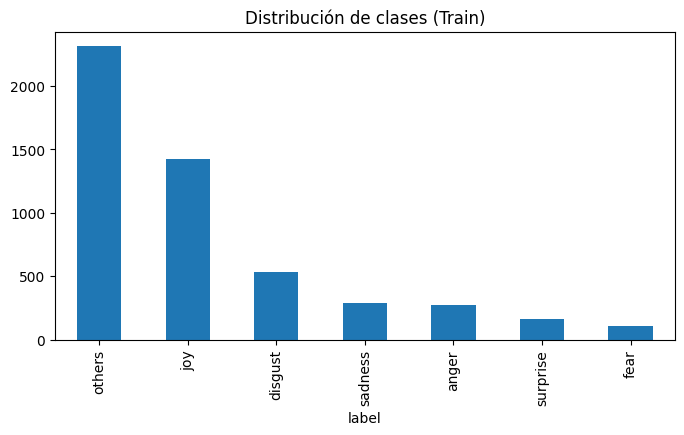

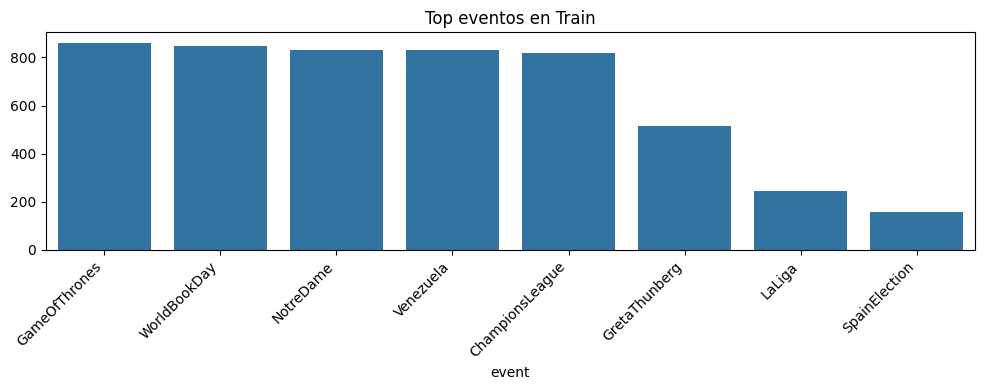

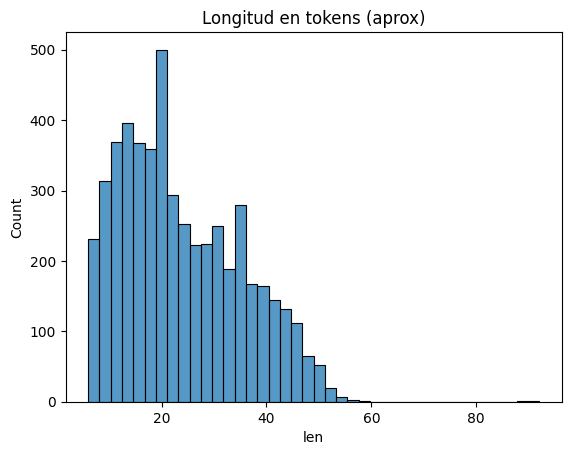

In [4]:

# Distribución de clases
fig, ax = plt.subplots(figsize=(8,4))
train_df['label'].value_counts().plot.bar(ax=ax)
plt.title("Distribución de clases (Train)")
plt.show()

# Distribución por evento (top 20)
top_events = train_df['event'].value_counts().head(20)
plt.figure(figsize=(10,4))
sns.barplot(x=top_events.index, y=top_events.values)
plt.title("Top eventos en Train")
plt.xticks(rotation=45, ha='right')
plt.tight_layout(); plt.show()

# Longitud de textos
train_df['len'] = train_df['text'].astype(str).str.split().apply(len)
sns.histplot(train_df['len'], bins=40)
plt.title("Longitud en tokens (aprox)")
plt.show()

train_df = train_df.drop(columns=['len'], errors='ignore')


## Mapeo de etiquetas

In [5]:

# Aseguramos un mapeo consistente label ↔ id
labels = sorted(train_df['label'].unique().tolist())
label2id = {l:i for i,l in enumerate(labels)}
id2label = {i:l for l,i in label2id.items()}

def apply_map(df):
    df = df.copy()
    df['label_id'] = df['label'].map(label2id)
    return df

train_df = apply_map(train_df)
dev_df   = apply_map(dev_df)
test_df  = apply_map(test_df)

num_labels = len(labels)
labels, num_labels, label2id


(['anger', 'disgust', 'fear', 'joy', 'others', 'sadness', 'surprise'],
 7,
 {'anger': 0,
  'disgust': 1,
  'fear': 2,
  'joy': 3,
  'others': 4,
  'sadness': 5,
  'surprise': 6})

## Modelo A — TF‑IDF + Regresión Logística

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

       anger     0.6000    0.0385    0.0723        78
     disgust     0.4286    0.1589    0.2319       151
        fear     0.0000    0.0000    0.0000        30
         joy     0.6136    0.5149    0.5599       404
      others     0.5197    0.8061    0.6320       655
     sadness     0.8710    0.3253    0.4737        83
    surprise     0.0000    0.0000    0.0000        46

    accuracy                         0.5460      1447
   macro avg     0.4333    0.2634    0.2814      1447
weighted avg     0.5336    0.5460    0.4976      1447



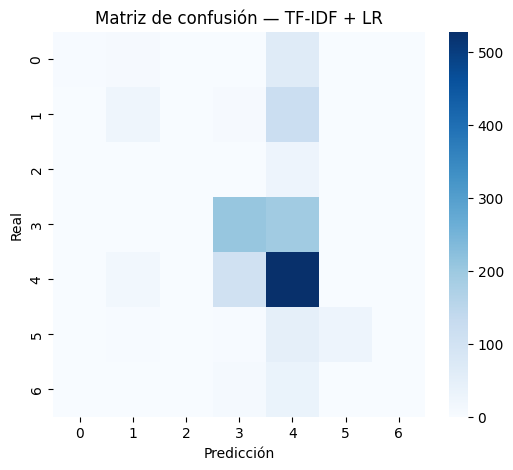

{'accuracy': 0.5459571527297857, 'macro_f1': 0.28138666650727806, 'weighted_f1': 0.4976483168596665}


In [6]:

from sklearn.pipeline import Pipeline

pipeline_lr = Pipeline([
    ('tfidf', TfidfVectorizer(
        min_df=2, max_df=0.9, ngram_range=(1,2),
        strip_accents='unicode'
    )),
    ('clf', LogisticRegression(max_iter=200, n_jobs=-1, C=2.0))
])

pipeline_lr.fit(train_df['text'].astype(str), train_df['label_id'])

pred_lr = pipeline_lr.predict(test_df['text'].astype(str))
print(classification_report(test_df['label_id'], pred_lr, target_names=labels, digits=4))

cm_lr = confusion_matrix(test_df['label_id'], pred_lr)
plt.figure(figsize=(6,5))
sns.heatmap(cm_lr, annot=False, cmap="Blues")
plt.title("Matriz de confusión — TF‑IDF + LR")
plt.xlabel("Predicción"); plt.ylabel("Real")
plt.show()

acc_lr = accuracy_score(test_df['label_id'], pred_lr)
f1m_lr = f1_score(test_df['label_id'], pred_lr, average='macro')
f1w_lr = f1_score(test_df['label_id'], pred_lr, average='weighted')
print({"accuracy":acc_lr, "macro_f1":f1m_lr, "weighted_f1":f1w_lr})


## Modelo B — BiLSTM con Keras (Embedding + BiLSTM + Dropout)

Epoch 1/12


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


80/80 ━━━━━━━━━━━━━━━━━━━━ 29s 316ms/step - accuracy: 0.4172 - loss: 1.5908 - val_accuracy: 0.4704 - val_loss: 1.3637
Epoch 2/12
80/80 ━━━━━━━━━━━━━━━━━━━━ 38s 278ms/step - accuracy: 0.5037 - loss: 1.2836 - val_accuracy: 0.4839 - val_loss: 1.3401
Epoch 3/12
80/80 ━━━━━━━━━━━━━━━━━━━━ 43s 301ms/step - accuracy: 0.6122 - loss: 1.0210 - val_accuracy: 0.4946 - val_loss: 1.4431
Epoch 4/12
80/80 ━━━━━━━━━━━━━━━━━━━━ 41s 301ms/step - accuracy: 0.7282 - loss: 0.7553 - val_accuracy: 0.5027 - val_loss: 1.8423
Epoch 5/12
80/80 ━━━━━━━━━━━━━━━━━━━━ 41s 297ms/step - accuracy: 0.8038 - loss: 0.5513 - val_accuracy: 0.4556 - val_loss: 1.8860
Epoch 6/12
80/80 ━━━━━━━━━━━━━━━━━━━━ 24s 300ms/step - accuracy: 0.8258 - loss: 0.4924 - val_accuracy: 0.4933 - val_loss: 2.0765
Epoch 7/12
80/80 ━━━━━━━━━━━━━━━━━━━━ 40s 289ms/step - accuracy: 0.8843 - loss: 0.3340 - val_accuracy: 0.4866 - val_loss: 2.4795
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 273ms/step
              precision    recall  f1-score   support

       anger  

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


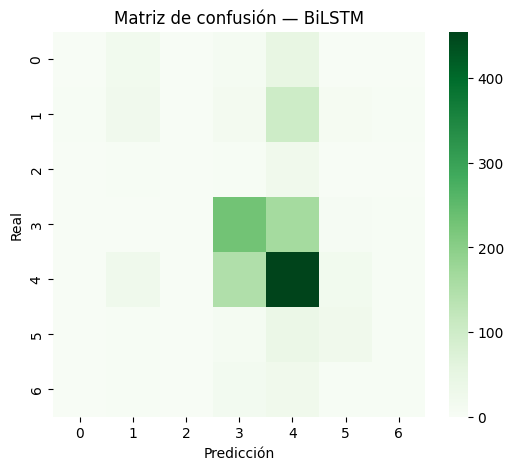

{'accuracy': 0.5086385625431928, 'macro_f1': 0.2537446034751639, 'weighted_f1': 0.47033673656885444}


In [22]:

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

MAX_VOCAB = 30000
MAX_LEN = 60
EMB_DIM = 128

tk = Tokenizer(num_words=MAX_VOCAB, oov_token="<unk>")
tk.fit_on_texts(pd.concat([train_df['text'], dev_df['text']] , axis=0).astype(str))

def to_seq(texts):
    seq = tk.texts_to_sequences(texts.astype(str))
    return pad_sequences(seq, maxlen=MAX_LEN, padding='post', truncating='post')

X_tr = to_seq(train_df['text']); y_tr = train_df['label_id'].values
X_dv = to_seq(dev_df['text']);   y_dv = dev_df['label_id'].values
X_te = to_seq(test_df['text']);  y_te = test_df['label_id'].values

tf.random.set_seed(42)

model = Sequential([
    Embedding(input_dim=min(MAX_VOCAB, len(tk.word_index)+1), output_dim=EMB_DIM, input_length=MAX_LEN),
    Bidirectional(LSTM(128, return_sequences=False)),
    Dropout(0.4),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(num_labels, activation='softmax')
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
es = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

history = model.fit(
    X_tr, y_tr,
    validation_data=(X_dv, y_dv),
    epochs=12, batch_size=64, callbacks=[es], verbose=1
)

pred_b = model.predict(X_te, batch_size=256).argmax(axis=1)

print(classification_report(y_te, pred_b, target_names=labels, digits=4))

cm_b = confusion_matrix(y_te, pred_b)
plt.figure(figsize=(6,5))
sns.heatmap(cm_b, annot=False, cmap="Greens")
plt.title("Matriz de confusión — BiLSTM")
plt.xlabel("Predicción"); plt.ylabel("Real")
plt.show()

acc_b = accuracy_score(y_te, pred_b)
f1m_b = f1_score(y_te, pred_b, average='macro')
f1w_b = f1_score(y_te, pred_b, average='weighted')
print({"accuracy":acc_b, "macro_f1":f1m_b, "weighted_f1":f1w_b})


##  Modelo D: Sentence Embeddings + SVM


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Encoding:   0%|          | 0/10 [00:00<?, ?it/s]

Encoding:   0%|          | 0/2 [00:00<?, ?it/s]

Encoding:   0%|          | 0/3 [00:00<?, ?it/s]


=== Modelo D: Embeddings + SVM ===
              precision    recall  f1-score   support

       anger     0.4000    0.0513    0.0909        78
     disgust     0.4444    0.2649    0.3320       151
        fear     1.0000    0.0333    0.0645        30
         joy     0.6552    0.6114    0.6325       404
      others     0.5708    0.7939    0.6641       655
     sadness     0.6491    0.4458    0.5286        83
    surprise     0.0000    0.0000    0.0000        46

    accuracy                         0.5867      1447
   macro avg     0.5314    0.3144    0.3304      1447
weighted avg     0.5672    0.5867    0.5484      1447

{'accuracy': 0.5867311679336559, 'macro_f1': 0.3303688073431816, 'weighted_f1': 0.5484139389508392}


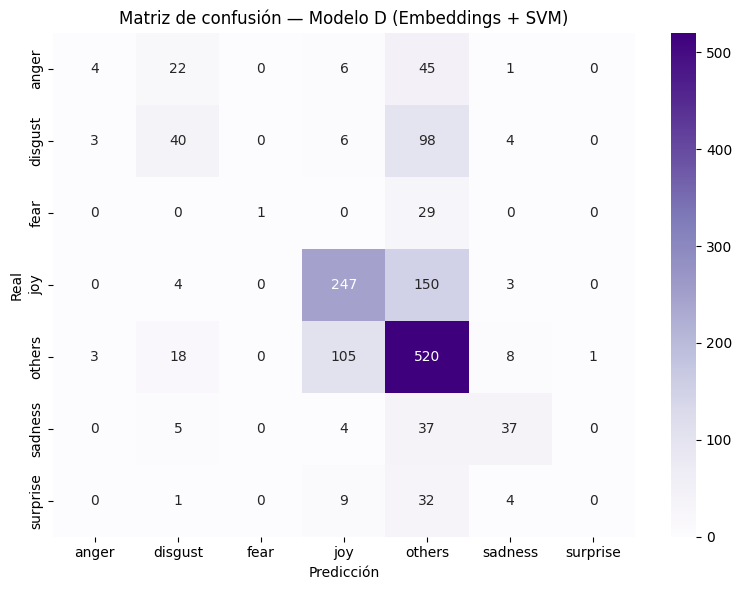


Top eventos — Modelo D (Embeddings + SVM)


,event,n,accuracy,macro_f1,weighted_f1
5,SpainElection,36,0.750000,0.449153,0.681497
7,WorldBookDay,225,0.684444,0.345692,0.671826
4,NotreDame,233,0.553648,0.323124,0.516431
3,LaLiga,68,0.735294,0.297874,0.710505
0,ChampionsLeague,253,0.549407,0.282672,0.508451
1,GameOfThrones,227,0.563877,0.261892,0.516459
6,Venezuela,258,0.534884,0.251455,0.459676
2,GretaThunberg,147,0.571429,0.249910,0.528738


In [27]:
# ===============================
#  Modelo D: Sentence Embeddings + SVM
# ===============================
!pip -q install sentence-transformers==3.0.1

import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from sentence_transformers import SentenceTransformer
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import os

# --- Encoder (multilingüe) ---
EMB_MODEL = "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"
enc = SentenceTransformer(EMB_MODEL)

def encode_texts(texts, batch_size=256):
    vecs = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Encoding"):
        batch = texts[i:i+batch_size]
        embs = enc.encode(
            batch,
            batch_size=min(128, batch_size),
            convert_to_numpy=True,
            normalize_embeddings=True,
            show_progress_bar=False
        )
        vecs.append(embs)
    return np.vstack(vecs)

# --- Generar embeddings ---
X_train = encode_texts(train_df["text"].tolist(), batch_size=512)
X_dev   = encode_texts(dev_df["text"].tolist(),   batch_size=512)
X_test  = encode_texts(test_df["text"].tolist(),  batch_size=512)

y_train = train_df["label_id"].values
y_dev   = dev_df["label_id"].values
y_test  = test_df["label_id"].values

# --- Entrenar clasificador SVM ---
clf = LinearSVC()
clf.fit(X_train, y_train)

# --- Predicciones ---
pred_d = clf.predict(X_test)

# --- Reporte general ---
print("\n=== Modelo D: Embeddings + SVM ===")
print(classification_report(y_test, pred_d, target_names=labels, digits=4, zero_division=0))

acc_d = accuracy_score(y_test, pred_d)
f1m_d = f1_score(y_test, pred_d, average="macro", zero_division=0)
f1w_d = f1_score(y_test, pred_d, average="weighted", zero_division=0)
print({"accuracy": acc_d, "macro_f1": f1m_d, "weighted_f1": f1w_d})

# --- Matriz de confusión ---
cm_d = confusion_matrix(y_test, pred_d, labels=list(range(len(labels))))
plt.figure(figsize=(8,6))
sns.heatmap(cm_d, annot=True, fmt="d", cmap="Purples",
            xticklabels=labels, yticklabels=labels)
plt.title("Matriz de confusión — Modelo D (Embeddings + SVM)")
plt.xlabel("Predicción"); plt.ylabel("Real")
plt.tight_layout(); plt.show()

# --- Métricas por evento ---
df_ev_d = per_event_scores(test_df, y_test, pred_d)
print("\nTop eventos — Modelo D (Embeddings + SVM)")
display(df_ev_d.head(10))

# --- Guardado de artefactos ---
os.makedirs("resultados", exist_ok=True)
pd.DataFrame(cm_d).to_csv("resultados/emb_svm_confusion_matrix.csv", index=False)
df_ev_d.to_csv("resultados/emb_svm_event_scores.csv", index=False)


## 6. Análisis por evento

In [33]:
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, f1_score, cohen_kappa_score,
    confusion_matrix
)

def _event_distribution_stats(y_true_ev, labels):
    """Devuelve etiqueta dominante, su proporción y entropía de la distribución."""
    cnt = Counter(y_true_ev)
    n = len(y_true_ev)
    if n == 0:
        return None, 0.0, 0.0
    lab_id, freq = cnt.most_common(1)[0]
    dominant_label = labels[lab_id]
    p_dom = freq / n
    # entropía (base 2)
    probs = np.array([c/n for c in cnt.values()], dtype=float)
    entropy = -np.sum(probs * np.log2(np.clip(probs, 1e-12, 1.0)))
    return dominant_label, p_dom, entropy

def _top_confusions(y_true_ev, y_pred_ev, labels, top_k=3):
    """Retorna las top-k confusiones Real->Pred (excluye aciertos)."""
    if len(y_true_ev) == 0:
        return []
    cm = confusion_matrix(y_true_ev, y_pred_ev, labels=list(range(len(labels))))
    pairs = []
    for i in range(len(labels)):
        for j in range(len(labels)):
            if i != j and cm[i, j] > 0:
                pairs.append(((labels[i], labels[j]), int(cm[i, j])))
    pairs.sort(key=lambda x: x[1], reverse=True)
    return [f"{a}→{b} ({n})" for (a,b), n in pairs[:top_k]]

def per_event_scores_plus(
    df, y_true, y_pred, labels, event_col='event', min_n=1, top_k_errors=3
):
    """
    Reporte por evento con métricas extendidas, baseline de mayoría y top errores.
    - min_n: ignora eventos con menos de min_n ejemplos.
    """
    rows = []
    g = df.groupby(event_col).indices
    for ev, idxs in g.items():
        idxs = list(idxs)
        if len(idxs) < min_n:
            continue
        y_t = y_true[idxs]
        y_p = y_pred[idxs]

        # distribución y baseline
        dominant_label, dom_share, entropy = _event_distribution_stats(y_t, labels)
        # métricas
        acc   = accuracy_score(y_t, y_p)
        bacc  = balanced_accuracy_score(y_t, y_p)
        f1_m  = f1_score(y_t, y_p, average='macro', zero_division=0)
        f1_w  = f1_score(y_t, y_p, average='weighted', zero_division=0)
        kappa = cohen_kappa_score(y_t, y_p)
        # baseline: “si siempre predijera la clase dominante” -> acc = dom_share
        baseline_acc = dom_share

        # top errores
        confs = _top_confusions(y_t, y_p, labels, top_k=top_k_errors)

        rows.append({
            "event": ev,
            "n": len(idxs),
            "dominant_label": dominant_label,
            "dominant_share": round(baseline_acc, 4),
            "entropy": round(entropy, 3),
            "accuracy": round(acc, 4),
            "balanced_acc": round(bacc, 4),
            "macro_f1": round(f1_m, 4),
            "weighted_f1": round(f1_w, 4),
            "kappa": round(kappa, 4),
            "top_errors": "; ".join(confs) if confs else ""
        })
    # orden por macro_f1 (puedes cambiar a balanced_acc o lo que prefieras)
    return pd.DataFrame(rows).sort_values(["macro_f1","n"], ascending=[False, False]).reset_index(drop=True)


In [35]:
y_test = test_df["label_id"].values

df_ev_lr = per_event_scores_plus(test_df, y_test, pred_lr, labels, min_n=5, top_k_errors=3)
df_ev_b  = per_event_scores_plus(test_df, y_test, pred_b,  labels, min_n=5, top_k_errors=3)
df_ev_d  = per_event_scores_plus(test_df, y_test, pred_d,  labels, min_n=5, top_k_errors=3)

print("Top eventos — TFIDF+LR"); display(df_ev_lr.head(10))
print("Top eventos — BiLSTM");   display(df_ev_b.head(10))
print("Top eventos — Embeddings+SVM"); display(df_ev_d.head(10))


Top eventos — TFIDF+LR


,event,n,dominant_label,dominant_share,entropy,accuracy,balanced_acc,macro_f1,weighted_f1,kappa,top_errors
0,SpainElection,36,others,0.7222,1.130,0.7500,0.4538,0.4492,0.6815,0.2340,fear→others (5); joy→others (3); others→joy (1)
1,NotreDame,233,others,0.3476,2.331,0.4807,0.2652,0.2719,0.4323,0.2544,disgust→others (37); joy→others (23); sadness→...
2,WorldBookDay,225,joy,0.5022,1.306,0.6444,0.2709,0.2646,0.6302,0.3243,joy→others (36); others→joy (33); disgust→othe...
3,LaLiga,68,joy,0.5441,1.336,0.5882,0.2382,0.2295,0.5596,0.1856,others→joy (16); joy→others (8); sadness→other...
4,GameOfThrones,227,others,0.4053,2.078,0.5507,0.2161,0.1984,0.4800,0.2715,joy→others (30); others→joy (15); surprise→oth...
5,Venezuela,258,others,0.4922,2.114,0.5078,0.1923,0.1878,0.4078,0.1048,disgust→others (37); anger→others (30); joy→ot...
6,GretaThunberg,147,others,0.5102,1.872,0.5578,0.1847,0.1731,0.4760,0.1656,joy→others (26); disgust→others (16); fear→oth...
7,ChampionsLeague,253,others,0.4980,1.850,0.5059,0.1730,0.1656,0.4526,0.1091,joy→others (49); others→joy (32); disgust→othe...


Top eventos — BiLSTM


,event,n,dominant_label,dominant_share,entropy,accuracy,balanced_acc,macro_f1,weighted_f1,kappa,top_errors
0,SpainElection,36,others,0.7222,1.130,0.7778,0.4667,0.4794,0.7053,0.2836,fear→others (5); joy→others (3)
1,WorldBookDay,225,joy,0.5022,1.306,0.5156,0.2538,0.2756,0.5061,0.0752,others→joy (52); joy→others (47); disgust→joy (3)
2,NotreDame,233,others,0.3476,2.331,0.4378,0.2623,0.2582,0.3961,0.2211,disgust→others (29); joy→others (21); sadness→...
3,LaLiga,68,joy,0.5441,1.336,0.6324,0.2605,0.2525,0.6092,0.2821,others→joy (13); joy→others (8); sadness→other...
4,GameOfThrones,227,others,0.4053,2.078,0.5374,0.2235,0.2090,0.4825,0.2817,others→joy (24); joy→others (16); surprise→oth...
5,Venezuela,258,others,0.4922,2.114,0.4651,0.2105,0.2014,0.3947,0.1027,disgust→others (33); anger→others (23); others...
6,GretaThunberg,147,others,0.5102,1.872,0.5782,0.1953,0.1791,0.5027,0.2285,joy→others (20); disgust→others (17); others→j...
7,ChampionsLeague,253,others,0.4980,1.850,0.4743,0.1634,0.1498,0.4397,0.1159,others→joy (46); joy→others (34); disgust→othe...


Top eventos — Embeddings+SVM


,event,n,dominant_label,dominant_share,entropy,accuracy,balanced_acc,macro_f1,weighted_f1,kappa,top_errors
0,SpainElection,36,others,0.7222,1.130,0.7500,0.4538,0.4492,0.6815,0.2340,fear→others (5); joy→others (3); others→joy (1)
1,WorldBookDay,225,joy,0.5022,1.306,0.6844,0.3255,0.3457,0.6718,0.3987,others→joy (31); joy→others (30); disgust→joy (4)
2,NotreDame,233,others,0.3476,2.331,0.5536,0.3261,0.3231,0.5164,0.3829,disgust→others (24); joy→others (15); sadness→...
3,LaLiga,68,joy,0.5441,1.336,0.7353,0.3063,0.2979,0.7105,0.4831,others→joy (9); joy→others (5); anger→others (1)
4,ChampionsLeague,253,others,0.4980,1.850,0.5494,0.2542,0.2827,0.5085,0.2100,joy→others (39); others→joy (29); disgust→othe...
5,GameOfThrones,227,others,0.4053,2.078,0.5639,0.2568,0.2619,0.5165,0.3141,joy→others (24); others→joy (17); surprise→oth...
6,Venezuela,258,others,0.4922,2.114,0.5349,0.2462,0.2515,0.4597,0.2024,disgust→others (32); anger→others (20); anger→...
7,GretaThunberg,147,others,0.5102,1.872,0.5714,0.2343,0.2499,0.5287,0.2412,joy→others (21); disgust→others (15); others→j...


## 7. Comparativa global

In [36]:
# =============================
# Comparativa global de modelos
# =============================
summary = pd.DataFrame([
    {"model": "TFIDF+LR",       "accuracy": acc_lr, "macro_f1": f1m_lr, "weighted_f1": f1w_lr},
    {"model": "BiLSTM",         "accuracy": acc_b,  "macro_f1": f1m_b,  "weighted_f1": f1w_b},
    {"model": "Embeddings+SVM", "accuracy": acc_d,  "macro_f1": f1m_d,  "weighted_f1": f1w_d},
])

summary = summary.sort_values("macro_f1", ascending=False).reset_index(drop=True)
display(summary.style.format({
    "accuracy": "{:.4f}",
    "macro_f1": "{:.4f}",
    "weighted_f1": "{:.4f}"
}))


,model,accuracy,macro_f1,weighted_f1
0,Embeddings+SVM,0.5867,0.3304,0.5484
1,TFIDF+LR,0.5460,0.2814,0.4976
2,BiLSTM,0.5086,0.2537,0.4703


Conclusión comparativa por evento y global

Al comparar los tres modelos evaluados, se observa que Embeddings + SVM ofrece el mejor rendimiento global, alcanzando la mayor exactitud (≈58.7%) y el mejor balance entre clases (macro-F1 ≈0.33). Este enfoque demuestra ser más robusto para capturar variaciones emocionales en distintos eventos, mostrando consistencia tanto en contextos balanceados como desbalanceados.